## Построение амплитудо фазовой зависимости

параметры симуляции

a = [0.1, 0.003, 0.003, 0.1]
b = [0.2, 0.26, 0.26, 0.2]
c = [-65, -45, -45, -65]
d = [0.05, 2, 2, 0.05]

Время симуляции 20сек. Частота дискретизации 50т/мс.
Вход на сеть - белый шум с дисперсией 4mA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate
import os

from tqdm import tqdm

In [4]:
# Функция для расчета периода сигнала
def calc_T(T, signal):
    mean = np.mean(signal)
    mean_idx = np.where(np.logical_and(signal[1:] >= mean, signal[:-1] <= mean))
    T = np.mean(np.diff(T[mean_idx]))
    return T

# Функция для расчета фазовой разницы между двумя сигналами
def calc_df(T, signal1, signal2):
    # Расчет кросс-корреляции
    correlation = correlate(signal1, signal2, mode='full')
    period = calc_T(T, signal1)
    # Нахождение индекса максимальной корреляции
    lag = np.argmax(correlation) - (len(signal1) - 1)

    # Расчет временной задержки
    time_delay = lag * (T[1] - T[0])

    # Расчет фазовой разницы
    phase_difference = 2*np.pi*time_delay/period  # Умножение на частоту сигнала
    return phase_difference

def calc_ampl_fft(T, Q, mask):
    n_samples = len(Q[mask])
    np_fft = np.fft.fft(Q[mask] - np.mean(Q[mask]))
    amplitudes = 2 / n_samples * np.abs(np_fft)
    phases = np.angle(np_fft)
    frequencies = np.fft.fftfreq(n_samples) * n_samples * 1 / (T[mask][-1] - T[mask][0])
    max_a_id = np.argmax(amplitudes)
    Ampl = amplitudes[max_a_id]
    freq=frequencies[max_a_id]
    ph = phases[max_a_id]
    return Ampl, freq, ph

In [73]:
# Функция для анализа зависимости между амплитудой и фазой
def analyze_amplitude_phase(data_csv):
    data = pd.read_csv(data_csv)
    data1 = pd.DataFrame({
        'w1': [],
        'q': [],
        'tau': [],
        'dphi' : [],
        'Q_ampl' : [],
        'Q_freq' : [],
        'F_path' : [],
        'Q_path' : [],
        'V_path': [],
        'Aff_path': []
    })
    T = np.load(os.path.join(os.path.dirname(data_csv), 'T.npy'))
    mask = T > 0
    with tqdm(total=len(data)) as pbar:
        for index, row in data.iterrows():
            F = np.load(row['F_path'])
            F_f = F[0]
            F_e = F[1]
            Q = np.load(row['Q_path'])

            # Расчет фазовой разницы и периода
            phase_difference = calc_df(T[mask], F_f[mask], F_e[mask])
            if abs(phase_difference) > 20:
                phase_difference = np.nan
            # Расчет амплитуды Q
            amplitude_Q, freq, _ = calc_ampl_fft(T, Q, mask)
            if amplitude_Q > np.pi/2:
                amplitude_Q = np.nan
            
            # Сохранение результатов
            data1.loc[index] = [
                row['w1'], row['q'], row['tau'], phase_difference%(2*np.pi),
                amplitude_Q, freq, row['F_path'], row['Q_path'], row['V_path'], row['Aff_path']
            ]
            pbar.update(1)
    return data1

def clean_data(directory):
    # load data from csv file
    data_processed = pd.read_csv(os.path.join(directory, 'data_processed.csv'))
    # Drop nan values from data frame
    data_processed_cleaned = data_processed.dropna()
    # Save new data
    data_processed_cleaned.to_csv(os.path.join(directory, 'data_processed_cleaned.csv'))
    

In [79]:
# Пример использования
data_dir='./exp_afferents'
data_csv = f'{data_dir}/data.csv'
data_processed = analyze_amplitude_phase(data_csv)
data_processed.to_csv(os.path.join(os.path.dirname(data_csv), 'data_processed.csv'))
clean_data(data_dir)

/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 28/28 [00:10<00:00,  2.60it/s]


# Processing data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


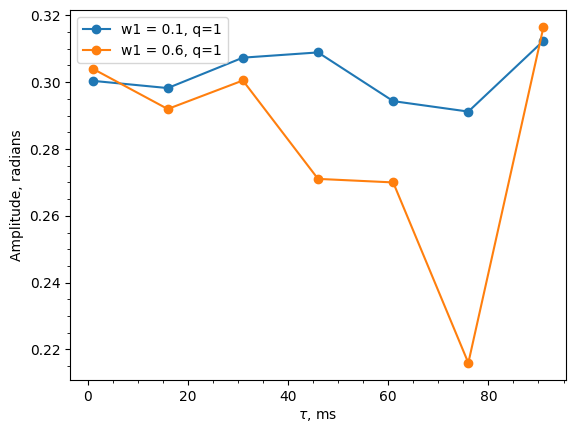

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


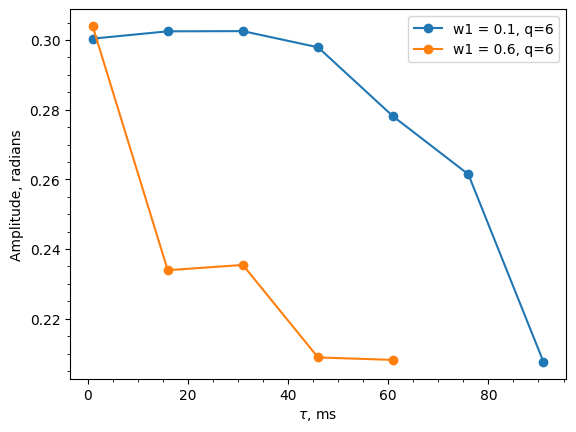

np.int64(20)

In [80]:
# plotting Ampl(dphi) dependence
T = np.load(os.path.join(os.path.dirname(data_csv), 'T.npy'))
data = pd.read_csv(f'./{data_dir}/data_processed_cleaned.csv')
#df = data_processed_cleaned[data_processed_cleaned['w1'].round(2).isin([0.1, 0.5, 0.9])]
df = data.groupby('q')
# Построение графиков для каждой группы
#plt.figure(figsize=(12, 8))

# Цикл по группам
for q, group in df:
    sorted_group = group.sort_values(by='tau')

    q_group = sorted_group.groupby('w1')
    for w1, gr in q_group:
        plt.plot(gr['tau'], gr['Q_ampl'], marker='o', linestyle='-', label=f'w1 = {np.round(w1, 2)}, q={np.round(q, 2)}')
        plt.xlabel(r"$\tau$, ms")
        plt.ylabel('Amplitude, radians')
        plt.minorticks_on()
        plt.legend()
    plt.savefig(f'{data_dir}/img/sys_{round(w1, 1)}_{round(q, 1)}.eps')
    plt.show()

data['Q_ampl'].argmax()

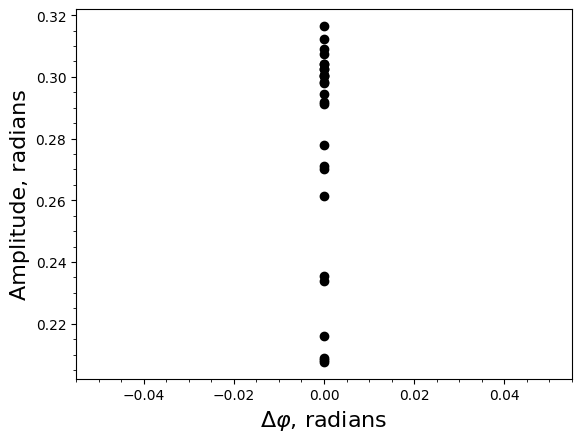

In [81]:
df_sorted_by_dphi = data.sort_values(by='dphi')
plt.scatter(df_sorted_by_dphi['dphi'], df_sorted_by_dphi['Q_ampl'], marker='o', color='k')
plt.minorticks_on()
plt.xlabel(r'$\Delta\varphi$, radians', fontsize=16)
plt.ylabel('Amplitude, radians', fontsize=16)
plt.savefig(f'./{data_dir}/img/Ampl_phase.eps')

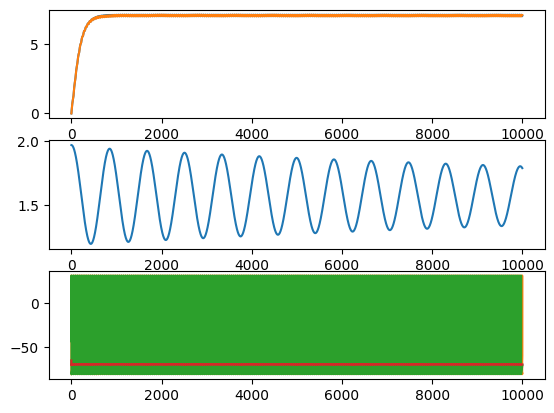

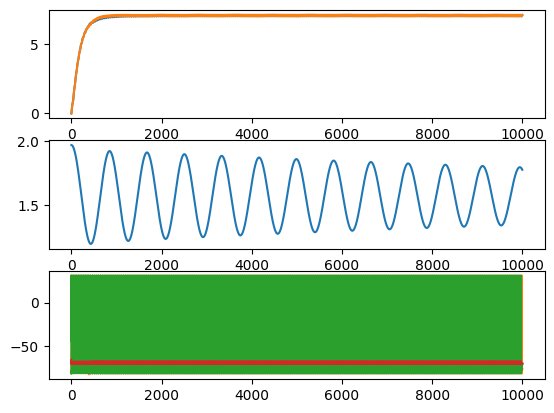

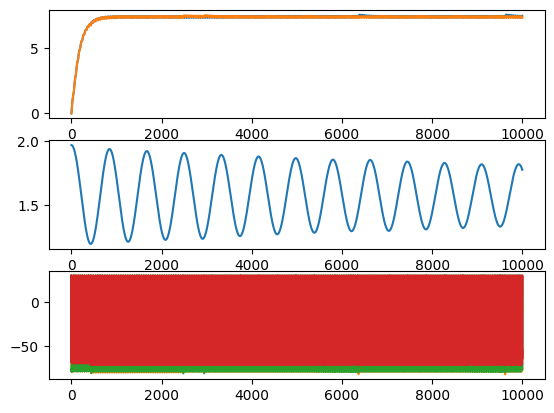

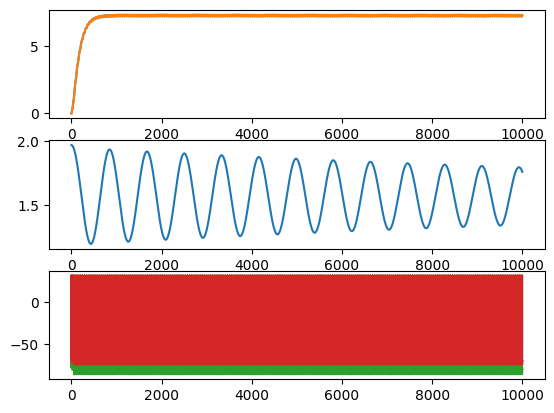

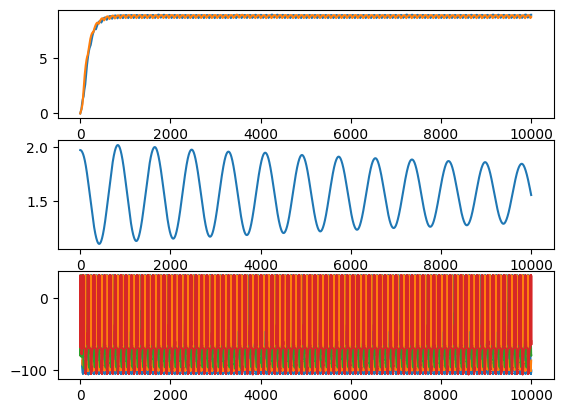

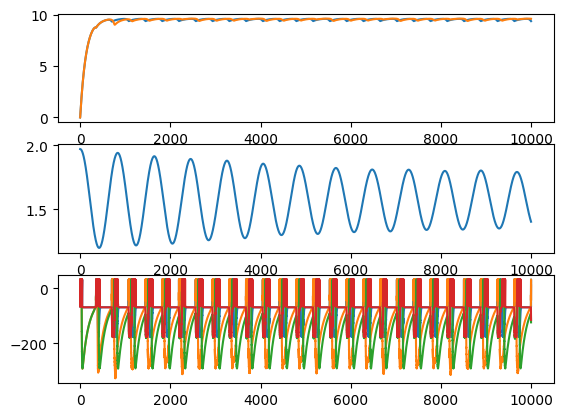

In [82]:
for i in range(0, len(data), 5):
    F = np.load(data.loc[i]['F_path'])
    # Функция для расчета периода сигнала
    mask = T>0
    p =  calc_T(T[mask], F[0][mask])
    plt.subplot(311)
    plt.plot(T[mask], F[0][mask])
    plt.plot(T[mask], F[1][mask])
    plt.subplot(312)
    Q = np.load(data.loc[i]['Q_path'])
    plt.plot(T[mask], Q[mask])
    V = np.load(data.loc[i]['V_path'])
    plt.subplot(313)
    for i in range(4):
        plt.plot(T[mask], V[:, i][mask], label=f'n{i}')
    plt.show()


In [83]:
F = np.load(data.loc[29]['F_path'])
# Функция для расчета периода сигнала
mask = T>0
p =  calc_T(T[mask], F[0][mask])
plt.subplot(311)
plt.plot(T[mask], F[0][mask])
plt.plot(T[mask], F[1][mask])
plt.subplot(312)
Q = np.load(data.loc[29]['Q_path'])


plt.plot(T[mask], Q[mask])
V = np.load(data.loc[29]['V_path'])
plt.subplot(313)
for i in range(4):
    plt.plot(T[mask], V[:, i][mask], label=f'n{i}')
plt.show()

KeyError: 29